In [149]:
!git clone https://github.com/mohamedamine99/Visualizing-what-convnets-learn

fatal: destination path 'Visualizing-what-convnets-learn' already exists and is not an empty directory.


In [150]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model

import os
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np


In [151]:
CNN_model_path = '/content/Visualizing-what-convnets-learn/models/CNN cats vs dogs model.hdf5'
test_imgs_path = '/content/Visualizing-what-convnets-learn/test images'

In [152]:
CNN_model = load_model(CNN_model_path)
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_5 (Batc  (None, 61, 61, 64)      

dog.PNG
[[0.99410754]]
0.99410754
2 dogs.PNG
[[0.99938726]]
0.99938726
cat.PNG
[[9.113619e-05]]
9.113619e-05
2 cats.PNG
[[4.815186e-09]]
4.815186e-09


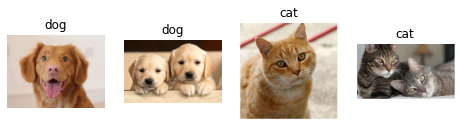

In [153]:
# testing and visualizing CNN model predictions
labels = ["cat","dog"]
pre_processed_imgs = []
ncols = len(os.listdir(test_imgs_path))
fig = plt.figure(figsize=(8, 5))
for i , img_file in enumerate(os.listdir(test_imgs_path)):
    print(img_file)
    img = cv2.imread(os.path.join(test_imgs_path,img_file))
    if (img is None):
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig.add_subplot(1, ncols, i+1)
    plt.imshow(img)
    plt.axis('off')
    
    img = cv2.resize(img,(128,128))
    img = img / 255
    img = np.reshape(img,(1,128,128,3))
    pre_processed_imgs.append(img)
    results = CNN_model.predict(img,verbose = 0)
    print(results)
    results = np.squeeze(results)
    plt.title(labels[np.round(results).astype(int)])

    print(results)
    

In [154]:
grads_model = Model(inputs =[CNN_model.input] , outputs = [CNN_model.get_layer('conv2d_6').output, CNN_model.output])

In [155]:
dog_img = pre_processed_imgs[0]
with tf.GradientTape() as tape:
    dog_img = tf.cast(dog_img, tf.float32)
    (last_conv_activations , predictions) = grads_model(dog_img)


print(predictions)
grads = tape.gradient(predictions, last_conv_activations )

print(type(grads))
print(grads.shape)
print(np.max(grads))
print(np.min(grads))


tf.Tensor([[0.9941076]], shape=(1, 1), dtype=float32)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 12, 12, 256)
0.0011115358
-0.0013071297


In [156]:
cast_grads = tf.cast(grads > 0 , tf.float32)
cast_last_conv_activations = tf.cast(last_conv_activations > 0 , tf.float32)
guided_grads = cast_grads * cast_last_conv_activations * grads


last_conv_activations = last_conv_activations[0]
guided_grads = guided_grads[0]

print(np.max(cast_grads))
print(np.min(cast_grads))

print(np.max(cast_last_conv_activations))
print(np.min(cast_last_conv_activations))

print(np.max(guided_grads))
print(np.min(guided_grads))

1.0
0.0
1.0
0.0
0.00019520662
0.0


In [157]:
weights = tf.reduce_mean(guided_grads, axis = (0,1))
weighted_activations = tf.multiply(weights, last_conv_activations)

print(np.max(weights))
print(np.min(weights))
print(weights.shape)

print(np.max(weighted_activations))
print(np.min(weighted_activations))
print(weighted_activations.shape)


3.849448e-06
0.0
(256,)
7.072627e-05
0.0
(12, 12, 256)


In [158]:
cam = tf.reduce_sum(weighted_activations, axis = -1)

print(np.max(cam))
print(np.min(cam))
print(cam.shape)

0.00041337364
9.548932e-05
(12, 12)


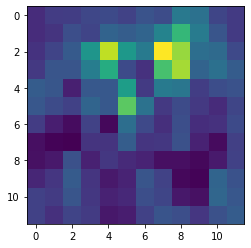

In [159]:
plt.imshow(cam)

430 323
0
255


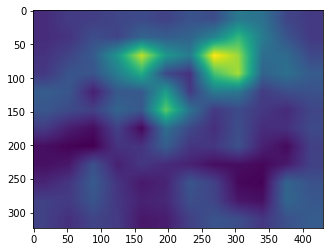

In [160]:
image = cv2.imread('/content/Visualizing-what-convnets-learn/test images/dog.PNG')
(w,h) = (image.shape[1], image.shape[0])
print(w,h)
heatmap = cv2.resize(cam.numpy() , (w,h))
heatmap = (heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min()) + 1e-5
heatmap = (heatmap * 255).astype("uint8")
print(np.min(heatmap))
print(np.max(heatmap))

plt.imshow(heatmap)

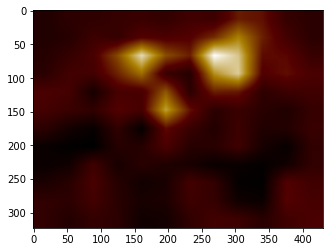

In [161]:
heatmap = cv2.applyColorMap(heatmap, 5)
plt.imshow(heatmap)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
output = cv2.addWeighted(image, 0.3, heatmap, 0.9, 0)
#plt.imshow(cv2.cvtColor(output,cv2.COLOR_BGR2RGB))

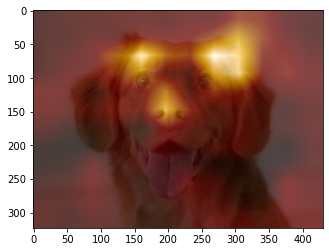

In [162]:
plt.imshow(output)